In [7]:
%matplotlib inline
 
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [8]:
import joblib
from skimage.io import imread
from skimage.transform import resize

data = 'archive/Garbage classification/Garbage classification'

def resize_all(src, pklname, include, width, height):
    
    data = dict()
    data['description'] = f'resized ({width}x{height})garbage images in rgb'
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
    
    pklname = f"{pklname}_{width}x{height}px.pkl"
    
    for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)
 
            for file in os.listdir(current_path):
                if file[-3:] in {'jpg', 'png'}:
                    im = imread(os.path.join(current_path, file))
                    im = resize(im, (width, height)) #[:,:,::-1]
                    data['label'].append(subdir)
                    data['filename'].append(file)
                    data['data'].append(im)
 
        joblib.dump(data, pklname)


data_path = 'archive/Garbage classification/Garbage classification'
os.listdir(data_path)

['paper', '.DS_Store', 'metal', 'cardboard', 'trash', 'glass', 'plastic']

In [9]:
base_name = 'garbage_classes'
width = 96
height = 128
 # We found that moderate resizing was optimal 
include = {'glass', 'paper', 'cardboard', 
           'metal', 'plastic', 'trash'}
 
resize_all(src=data_path, pklname=base_name, width=width, height=height, include=include)

paper
metal
cardboard
trash
glass
plastic


In [10]:
from collections import Counter
 
data = joblib.load(f'{base_name}_{width}x{height}px.pkl')
 
Counter(data['label'])

Counter({'paper': 594,
         'metal': 410,
         'cardboard': 403,
         'trash': 137,
         'glass': 501,
         'plastic': 482})

In [11]:
X = np.array(data['data'])
y = np.array(data['label'])

In [12]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin
import skimage
from skimage.feature import hog
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [20]:
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer

# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print(X_train_prepared.shape)

(2021, 1440)


In [21]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(max_depth=10, random_state=0)
rf_clf.fit(X_train_prepared, y_train)

RandomForestClassifier(max_depth=10, random_state=0)

In [22]:
# test the trained RF classifier
X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)

In [23]:
y_pred = rf_clf.predict(X_test_prepared)
print(np.array(y_pred == y_test)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

[False False False False False  True  True False  True False False False
  True False False False  True  True False  True False  True  True False
  True]

Percentage correct:  55.92885375494071


In [24]:
import pandas as pd
df = pd.DataFrame(
  np.c_[y_test, y_pred], 
  columns = ['labels', 'predictions']
)
df

,labels,predictions
0,glass,plastic
1,metal,glass
2,paper,glass
3,cardboard,paper
4,cardboard,glass
...,...,...
501,glass,cardboard
502,paper,paper
503,paper,paper
504,cardboard,cardboard


In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Define the pipeline with the Random Forest Classifier
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(14, 14), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys'
    )),
    ('scalify', StandardScaler()),
    ('classify', RandomForestClassifier(random_state=42))
])

clf = HOG_pipeline.fit(X_train, y_train)
print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))


Percentage correct:  55.33596837944664


In [29]:

# Define the parameter grid for GridSearchCV
param_grid = [
    {
        'classify__n_estimators': [100, 200],
        'classify__max_depth': [10, 20, None],
        'classify__min_samples_leaf': [1, 2]
    }
]

# Create a GridSearchCV object
grid_search = GridSearchCV(HOG_pipeline, 
                           param_grid, 
                           cv=3,
                           n_jobs=-1,
                           scoring='accuracy',
                           verbose=1,
                           return_train_score=True)
grid_res = grid_search.fit(X_train, y_train)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# View the best parameters and the corresponding score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

# Evaluate the model on the test set
best_pred = grid_search.predict(X_test)
test_accuracy = 100 * np.mean(best_pred == y_test)
print('Test set accuracy:', test_accuracy)

# save the model
joblib.dump(grid_search, 'rf_hog_optimized_model.pkl')

# detailed results of the grid search
df = pd.DataFrame(grid_search.cv_results_)
print(df[['param_classify__n_estimators', 'param_classify__max_depth', 'mean_test_score']])

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters found:  {'classify__max_depth': None, 'classify__min_samples_leaf': 1, 'classify__n_estimators': 200}
Best score found:  0.5536836257335727
Test set accuracy: 56.126482213438734
   param_classify__n_estimators param_classify__max_depth  mean_test_score
0                           100                        10         0.537856
1                           200                        10         0.535871
2                           100                        10         0.544781
3                           200                        10         0.544776
4                           100                        20         0.541811
5                           200                        20         0.550221
6                           100                        20         0.531905
7                           200                        20         0.551704
8        

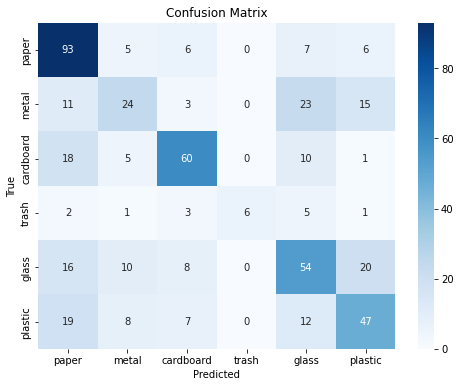

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

label_names = ['paper', 'metal', 'cardboard', 'trash', 'glass', 'plastic'] 
cmx = confusion_matrix(y_test, best_pred, labels=label_names)

df_cmx = pd.DataFrame(cmx, columns=label_names, index=label_names)

plt.figure(figsize=(8, 6))
sns.heatmap(df_cmx, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
